# Transfer Learning using a CNN

#### Steps: 

1) Organisation: Download labeled images and divide into training and validation folders

2) Data pipeline: Reading data, preprocessing, grouping multiple images into batches

3) Data augmentation: Small changes like rotation, zooming etc. to increase variation in training data

4) Model definition

5) Training & testing

6) Save the model for a potential application 

In [ ]:
# Image data we use for training
# https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data?select=train.zip
# (could use !wget ...)

# For image files, Keras will automatically assign the name of the class (category) based on its parent folder name
# After downloading the data and moving them to the project directory, execute in the terminal:
!unzip train.zip
%mv train data
%cd data
%mkdir train val
%mkdir train/cat train/dog
%mkdir val/cat val/dog

In [1]:
# Select randomly 250 images per class and place them into train and val folders
%ls | grep cat | sort -R | head -250 | xargs -I {} mv {} train/cat/
%ls | grep dog | sort -R | head -250 | xargs -I {} mv {} train/dog/
%ls | grep cat | sort -R | head -250 | xargs -I {} mv {} val/cat/
%ls | grep dog | sort -R | head -250 | xargs -I {} mv {} val/dog/

In [ ]:
!conda install -c conda-forge tensorflow --yes
!conda install -c conda-forge keras --yes
!conda install -c conda-forge pillow --yes
!conda install -c conda-forge matplotlib --yes

In [77]:
# Import packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math

In [78]:
# Configurations
# We treat this problem as a multiclass problem, i.e. "cats vs dogs" (Number of classes 2)
TRAIN_DATA_DIR = 'data/train/'
VALIDATION_DATA_DIR = 'data/val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

### Image Classification

- Input data are understood by DL algorithms as **tensors** (multidimensional array or list)

- Image data: 
    
    - Input batch of images 

    - 4D tensor:

<img src="Pictures/4_axis_tensor.png" style="width: 15%"/>


*https://www.tensorflow.org/guide/tensor*

- Images: 2 dimensions define Pixel values, 3rd RGB values, 4th number of images per batch

- In our case: $224*224*3*64$

In [80]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# ?ImageDataGenerator
# Generates batches of image data with real-time data augmentation
# Loops over the data in batches
# ImageDataGenerator is a function provided by keras for augmenting the data while they are loaded
# preprocess_input: scale pixel values (0-255) of rgb channels to 0-1

In [120]:
# Images are combined into batches, training single images is inefficient
# Shuffling to introduce more randomness
# Seed for reproducibility
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [136]:
# Model definition
# include_top = FALSE: Throw away last few specific layers (fully connected layers)
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False # freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # instantiate a Keras tensor
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation = 'relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [142]:
model = model_maker()
# model.summary()

# Information on MobileNet and its arguments:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md
# ?MobileNet

In [73]:
# Example code to check the layers in MobildeNet() and how many of them are trainable:
# base_model_test = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
# all layers
# for i, layer in enumerate(base_model_test.layers):
#   print(i, layer.name)
# trainable
# for i,layer in enumerate(base_model_test.layers[:]):
#   print(i,layer.name,layer.trainable)
# Use ':' (slice) to change the number of trainable layers 
# e.g. for layer in base_model_test.layers[:5]:
#    layer.trainable=False

In [138]:
# Model training (i.e. model fitting)
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001), 
              metrics=['acc'])
model.fit(
    train_generator, 
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE), 
    epochs=10, # epoch -> one full training step (network goes over entire dataset)
    validation_data=validation_generator, 
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE)) 
# Google colab can be used for running on GPU

Epoch 1/10
8/8 [==============================] - 38s 5s/step - loss: 0.5843 - acc: 0.7600 - val_loss: 0.1802 - val_acc: 0.9440
Epoch 2/10
8/8 [==============================] - 41s 5s/step - loss: 0.2139 - acc: 0.9040 - val_loss: 0.1095 - val_acc: 0.9560
Epoch 3/10
8/8 [==============================] - 40s 5s/step - loss: 0.1579 - acc: 0.9440 - val_loss: 0.0970 - val_acc: 0.9620
Epoch 4/10
8/8 [==============================] - 40s 5s/step - loss: 0.1063 - acc: 0.9520 - val_loss: 0.0826 - val_acc: 0.9640
Epoch 5/10
8/8 [==============================] - 40s 5s/step - loss: 0.0877 - acc: 0.9620 - val_loss: 0.0832 - val_acc: 0.9640
Epoch 6/10
8/8 [==============================] - 37s 5s/step - loss: 0.0695 - acc: 0.9740 - val_loss: 0.0777 - val_acc: 0.9660
Epoch 7/10
8/8 [==============================] - 33s 4s/step - loss: 0.0825 - acc: 0.9660 - val_loss: 0.0816 - val_acc: 0.9640
Epoch 8/10
8/8 [==============================] - 27s 3s/step - loss: 0.0829 - acc: 0.9740 - val_loss: 0

In [7]:
model.save('model_cd')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_cd/assets


In [139]:
# Testing the model on a sample image

# Load the model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('model_cd')

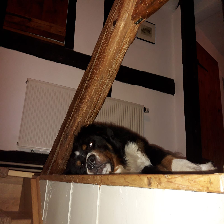

[[0.07485881 0.9251412 ]]
{'cat': 0, 'dog': 1}


In [141]:
# Load sample picture and check how the model performs
img_path = 'Pictures/sample_dog.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
display(img)
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image

# prediction > 0.5
# How does NN arrive at probabilities?
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

# Analyzing the results

## Important questions to ask: 
1. Which images is the model most confident about?

2. Which least confident?

3. Which images have incorrect predictions despite of having highly confident predictions from the model? 

# Data preparation

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = 'data/val/'
VALIDATION_BATCH_SIZE = 64

In [5]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=VALIDATION_BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 500 images belonging to 2 classes.


In [8]:
# Let's view the names of the files.
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:10])

500
['cat/cat.1000.jpg', 'cat/cat.1014.jpg', 'cat/cat.10147.jpg', 'cat/cat.10171.jpg', 'cat/cat.10252.jpg', 'cat/cat.10273.jpg', 'cat/cat.10280.jpg', 'cat/cat.10346.jpg', 'cat/cat.1044.jpg', 'cat/cat.10598.jpg']


In [10]:
ground_truth = validation_generator.classes
print(ground_truth[:10])
print(len(ground_truth))

[0 0 0 0 0 0 0 0 0 0]
500


In [13]:
# Can be skipped
# confirm which category names correspond to which category id
label_to_index = validation_generator.class_indices
print(label_to_index)

{'cat': 0, 'dog': 1}


In [16]:
# not necessary
print(label_to_index.items())

dict_items([('cat', 0), ('dog', 1)])


In [14]:
# Reverse mapping: from class index to class label
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{0: 'cat', 1: 'dog'}


In [20]:
# Get the predictions
predictions = model.predict(validation_generator,
                            steps=None)

In [21]:
print(predictions[:10])

[[9.9998319e-01 1.6751539e-05]
 [9.9999952e-01 4.8904383e-07]
 [9.9989402e-01 1.0597638e-04]
 [9.9997532e-01 2.4733848e-05]
 [9.9999297e-01 7.0923124e-06]
 [9.9973959e-01 2.6035617e-04]
 [9.9999964e-01 4.1070317e-07]
 [9.9998629e-01 1.3690113e-05]
 [9.9999988e-01 1.2149771e-07]
 [9.9995363e-01 4.6399738e-05]]


In [22]:
# Which probability values is higher?
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

In [25]:
# Helper function for calculating accurarcy
# remember ground truth: 0 -> cat; 1 -> dog
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)

In [26]:
# Accuracy for validation set
print(accuracy(prediction_index, ground_truth))

0.974


In [31]:
# Dictonary storing image index to prediction and ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability, index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [45]:
# Find images with highest/lowest probability value for a given category
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [52]:
# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

# Analysis

## Most confident results for dogs

<ipython-input-52-27501672227e>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)


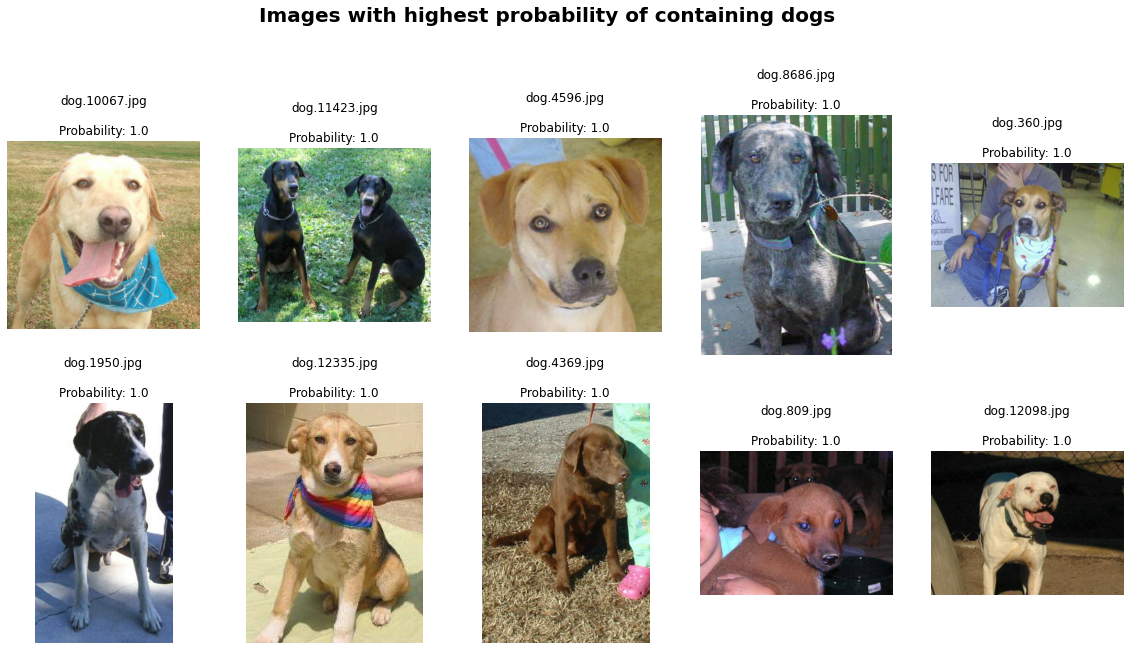

In [54]:
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               False)
message = 'Images with highest probability of containing dogs'
display(most_confident_dog_images[:10], message)

<ipython-input-52-27501672227e>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)


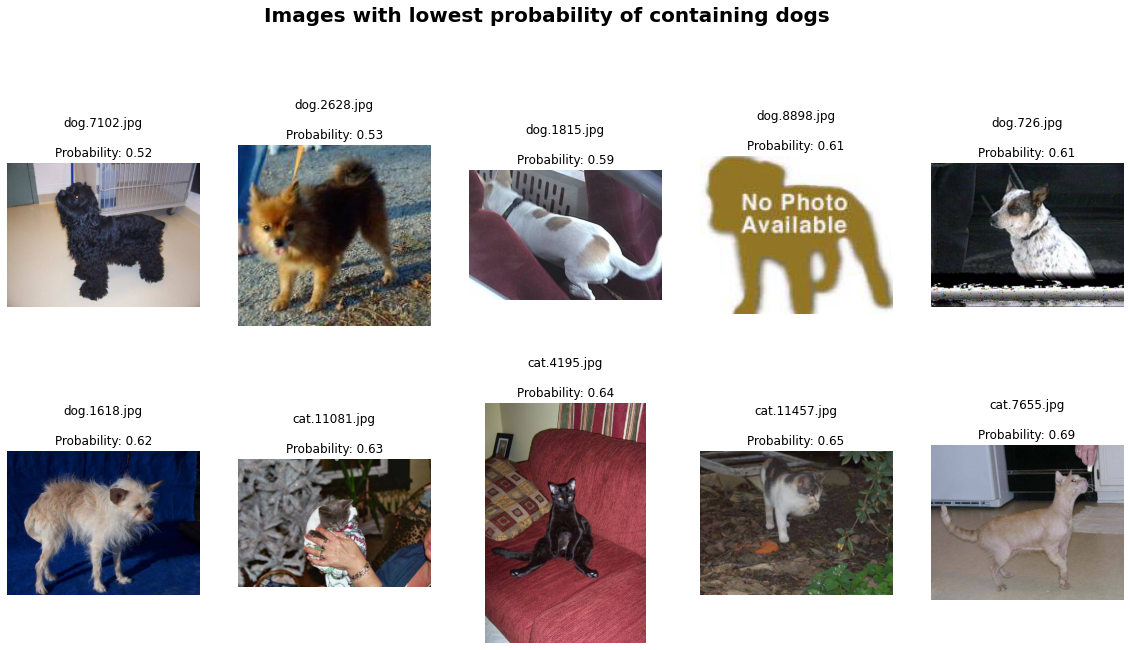

In [53]:
least_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, False, 1, 10,
                                               False)
message = 'Images with lowest probability of containing dogs'
display(least_confident_dog_images, message)

# False predictions among these images 

## We don't want misprediction when the classifier is sure of its predictions

<ipython-input-52-27501672227e>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)


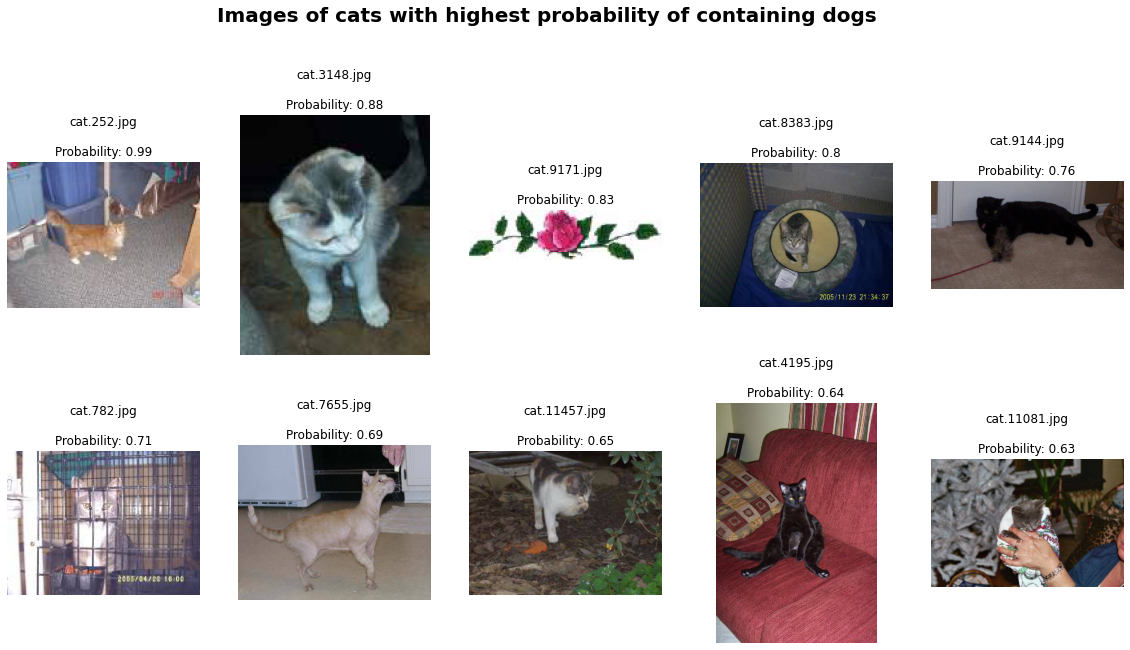

In [58]:
# only_false_predictions to TRUE
incorrect_dog_images = get_images_with_sorted_probabilities(prediction_table, 
                                                            get_highest_probability = True, 
                                                            label = 1, 
                                                            number_of_items = 10,
                                                            only_false_predictions = True)
message = 'Images of cats with highest probability of containing dogs'
display(incorrect_dog_images, message)

## Let's look at incorrect predictions of cats

<ipython-input-52-27501672227e>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)


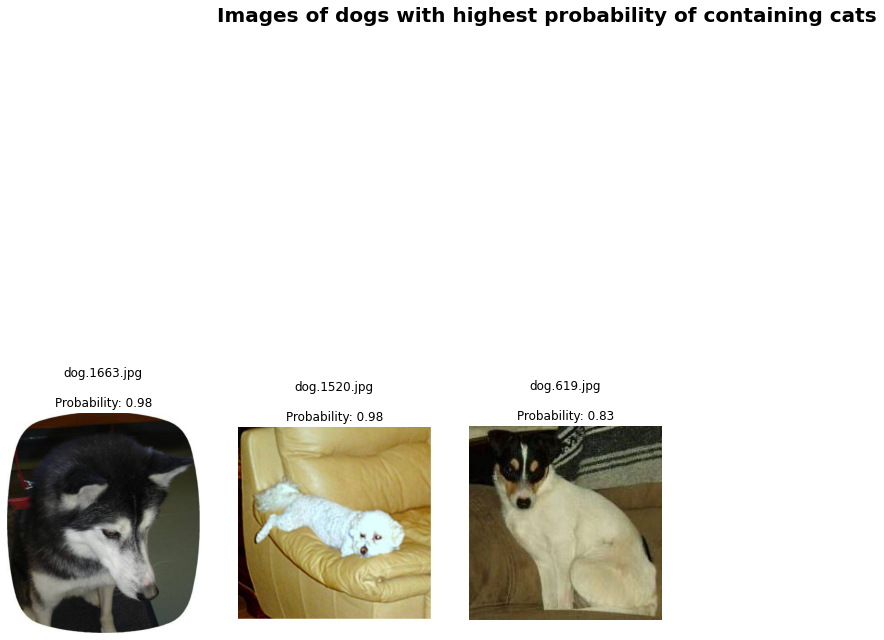

In [60]:
incorrect_cat_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10,
                                               True)
message = 'Images of dogs with highest probability of containing cats'
display(incorrect_cat_images, message)

## What to do?

- Acquire more training data

- Revise training data (wrong labels, images that show not the desired categories, items covering parts of the classified animals)

- Mispredictions: 
    - Too low or too high illumination
    - Size 
    - Difficult-to-distinguish backgrounds 